Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Task: Data Restructuring & Splitting ---
Restructured dataset already exists at '/content/plant_disease_data'

--- EDA: Dataset Split Distribution ---


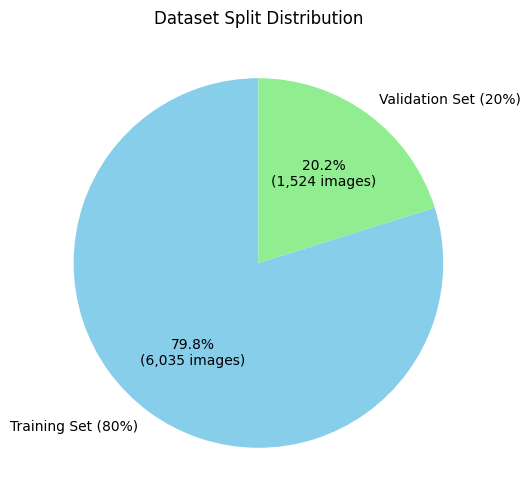


--- Running Image Integrity Check ---


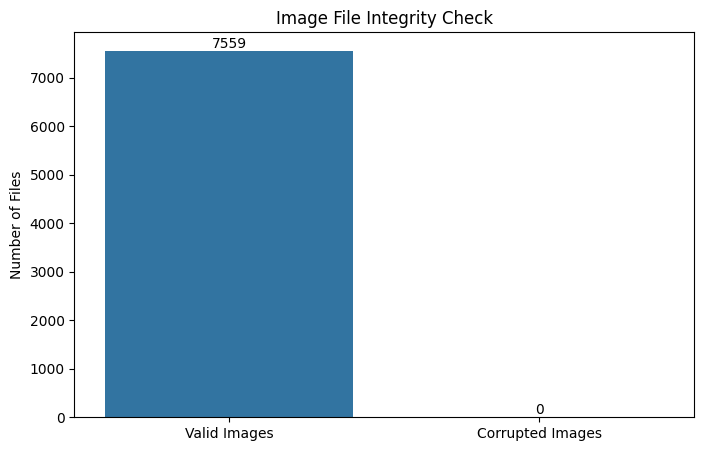


Conclusion: Scanned 7559 files and found 0 corrupted files.

--- Demonstrating Image Preprocessing Steps ---
Original image dimensions: (3000, 3000)
Processed image dimensions: (128, 128)
Pixel value range (Original): 0 to 255
Pixel value range (Normalized): 0.04 to 1.00


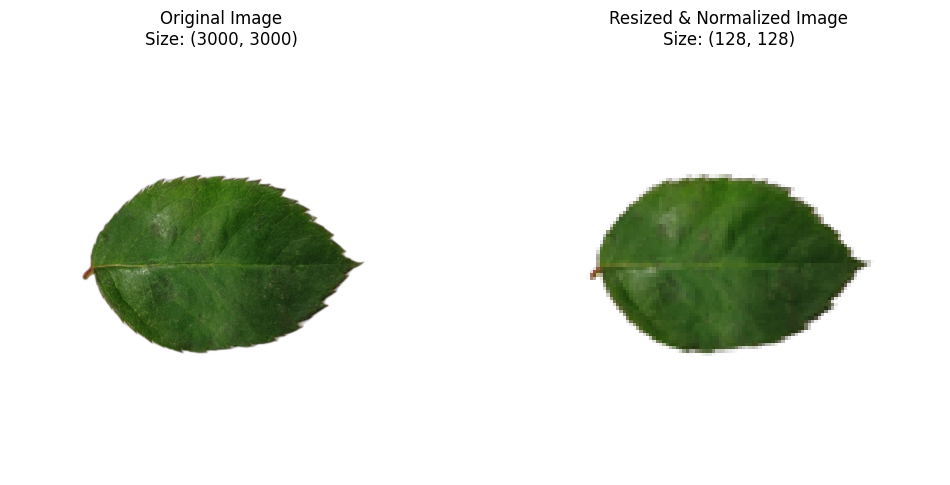

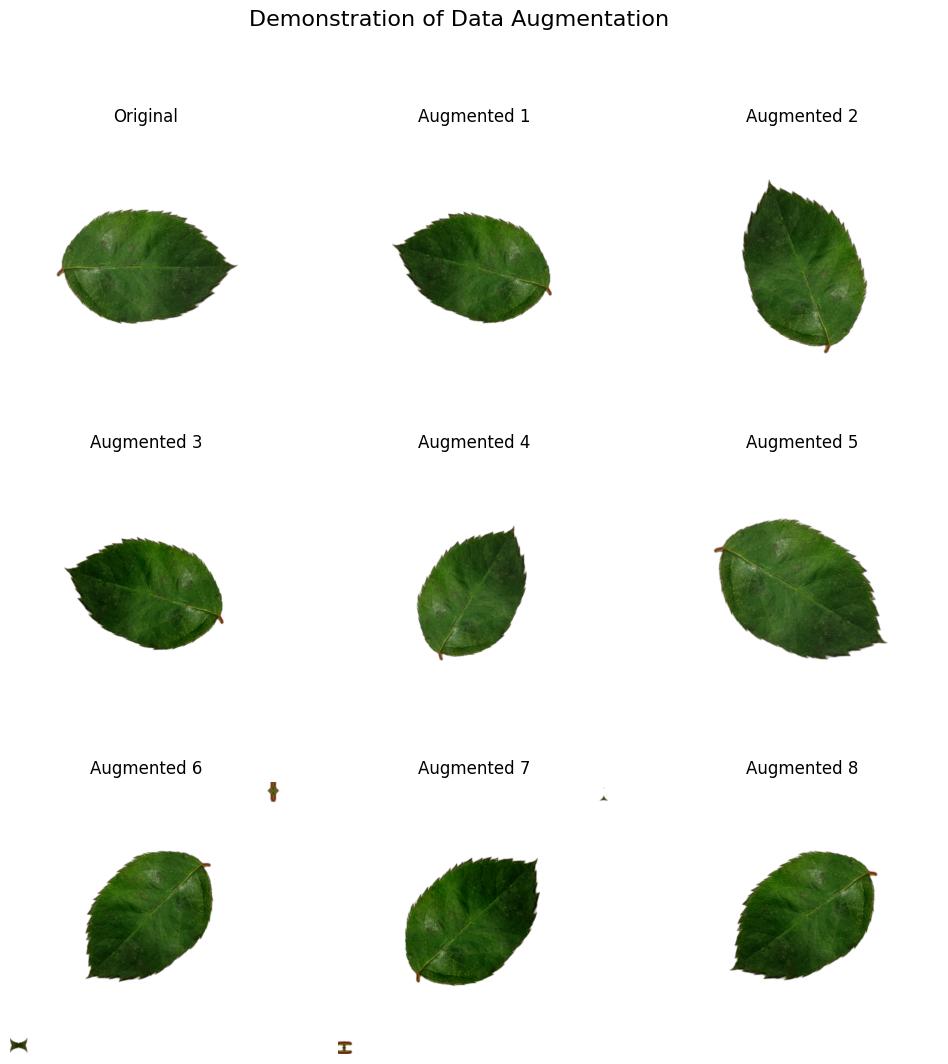


--- Demonstrating Label Encoding ---
Found 6035 files belonging to 29 classes.


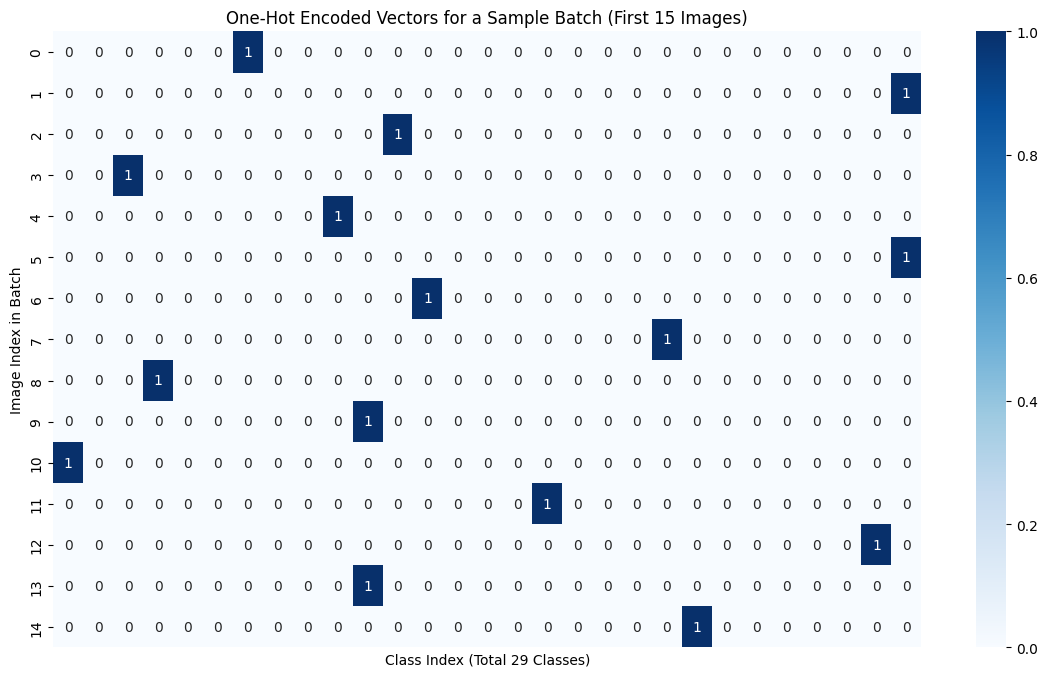

This heatmap visualizes the one-hot encoded vectors. Each row represents an image, and the '1' indicates its correct class.

--- Demonstrating Pipeline Optimization with .cache() and .prefetch() ---
Found 6035 files belonging to 29 classes.
Time to iterate through unoptimized dataset (2 epochs): 72.93 seconds
Time to iterate through optimized dataset (2 epochs): 34.92 seconds


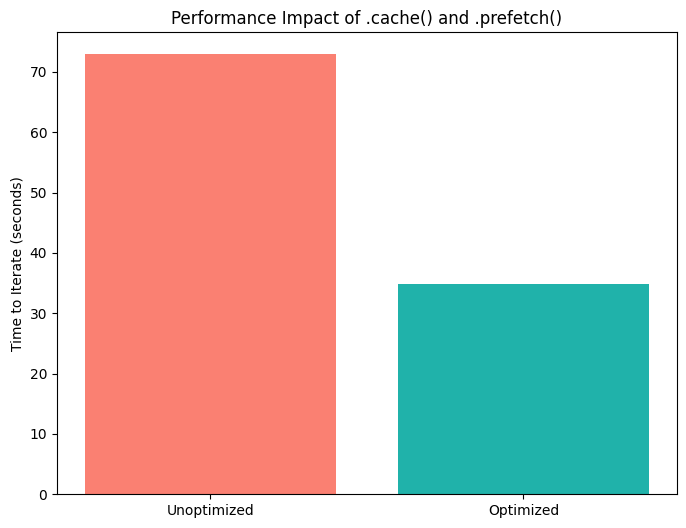

The bar chart shows a significant reduction in data loading time for the optimized pipeline, which will speed up our model training.

--- Step 1: Loading data, resizing images, and encoding labels... ---
Found 6035 files belonging to 29 classes.
Found 1524 files belonging to 29 classes.
Found 29 classes.

--- Step 2: Defining normalization and augmentation layers... ---

--- Step 3: Applying transformations and optimizing the data pipeline... ---

--- INTEGRATED PIPELINE COMPLETE ---
The 'train_ds' and 'val_ds' are now fully preprocessed and optimized for efficient model training.

Created new directory structure at: '/content/Final_Dataset_Processed'
Saving images to '/content/Final_Dataset_Processed/train'...
Finished saving 6035 images.
Saving images to '/content/Final_Dataset_Processed/valid'...
Finished saving 1524 images.

Zipping the processed dataset... This may take a few moments.
Successfully created 'Final_Dataset_Processed.zip' in the Colab environment.
SUCCESS: The preproc

In [7]:
# --- 1. SETUP AND IMPORTS ---
# All necessary libraries are imported once at the beginning.
import os
import shutil
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive to access the dataset (runs only once)
drive.mount('/content/drive')


# --- 2. DATA RESTRUCTURING & SPLITTING ---
print("--- Task: Data Restructuring & Splitting ---")
original_dataset_dir = '/content/drive/MyDrive/Final Dataset'
base_dir = '/content/plant_disease_data'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

if not os.path.exists(base_dir):
    print("Restructuring dataset into train/valid splits...")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    for plant_folder in os.listdir(original_dataset_dir):
        plant_path = os.path.join(original_dataset_dir, plant_folder)
        if os.path.isdir(plant_path):
            for disease_folder in os.listdir(plant_path):
                disease_path = os.path.join(plant_path, disease_folder)
                if os.path.isdir(disease_path):
                    files = [f for f in os.listdir(disease_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    train_files, valid_files = train_test_split(files, test_size=0.2, random_state=42)
                    class_name = f"{plant_folder.replace(' ', '')}_{disease_folder.replace(' ', '')}"

                    train_class_dir = os.path.join(train_dir, class_name)
                    valid_class_dir = os.path.join(valid_dir, class_name)
                    os.makedirs(train_class_dir, exist_ok=True)
                    os.makedirs(valid_class_dir, exist_ok=True)

                    for f in train_files:
                        shutil.copy(os.path.join(disease_path, f), os.path.join(train_class_dir, f))
                    for f in valid_files:
                        shutil.copy(os.path.join(disease_path, f), os.path.join(valid_class_dir, f))
    print("Dataset restructuring complete!")
else:
    print(f"Restructured dataset already exists at '{base_dir}'")


# --- 3. EDA: VISUALIZE DATA SPLIT ---
print("\n--- EDA: Dataset Split Distribution ---")
train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
valid_count = sum([len(files) for r, d, files in os.walk(valid_dir)])
total_count = train_count + valid_count

plt.figure(figsize=(8, 6))
plt.pie([train_count, valid_count],
        labels=['Training Set (80%)', 'Validation Set (20%)'],
        autopct=lambda p: '{:.1f}%\n({:,.0f} images)'.format(p, (p/100)*total_count),
        startangle=90, colors=['skyblue', 'lightgreen'])
plt.title("Dataset Split Distribution")
plt.show()


# --- 4. DATA CLEANING & VERIFICATION ---
print("\n--- Running Image Integrity Check ---")
corrupted_files_found = []
for directory in [train_dir, valid_dir]:
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupted file found: {file_path}")
                corrupted_files_found.append(file_path)

status_counts = {'Valid Images': total_count - len(corrupted_files_found), 'Corrupted Images': len(corrupted_files_found)}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(status_counts.keys()), y=list(status_counts.values()))
plt.title('Image File Integrity Check')
plt.ylabel('Number of Files')
for index, value in enumerate(status_counts.values()):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()
print(f"\nConclusion: Scanned {total_count} files and found {len(corrupted_files_found)} corrupted files.")


# --- 5. IMAGE PREPROCESSING & AUGMENTATION DEMONSTRATION ---
print("\n--- Demonstrating Image Preprocessing Steps ---")
IMAGE_SIZE = (128, 128)

# Pick a sample image to demonstrate transformations
sample_path = os.path.join(train_dir, 'Rose_Rose_Healthy', os.listdir(os.path.join(train_dir, 'Rose_Rose_Healthy'))[0])
original_img = Image.open(sample_path)

# 5a. Resize and Normalize
resized_img = original_img.resize(IMAGE_SIZE)
normalized_array = np.array(resized_img) / 255.0

print(f"Original image dimensions: {original_img.size}")
print(f"Processed image dimensions: {resized_img.size}")
print(f"Pixel value range (Original): {np.min(np.array(original_img))} to {np.max(np.array(original_img))}")
print(f"Pixel value range (Normalized): {np.min(normalized_array):.2f} to {np.max(normalized_array):.2f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title(f"Original Image\nSize: {original_img.size}")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(normalized_array)
plt.title(f"Resized & Normalized Image\nSize: {resized_img.size}")
plt.axis('off')
plt.show()

# 5b. Data Augmentation
data_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])
img_array = tf.keras.utils.img_to_array(Image.open(sample_path))
image_tensor = tf.expand_dims(img_array, 0)

plt.figure(figsize=(12, 12))
plt.suptitle("Demonstration of Data Augmentation", fontsize=16)
plt.subplot(3, 3, 1)
plt.imshow(img_array.astype("uint8"))
plt.title("Original")
plt.axis("off")
for i in range(2, 10):
    ax = plt.subplot(3, 3, i)
    augmented_image = data_augmentation_pipeline(image_tensor)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(f"Augmented {i-1}")
    plt.axis("off")
plt.show()


# --- 6. LABEL ENCODING & PIPELINE OPTIMIZATION DEMONSTRATION ---
print("\n--- Demonstrating Label Encoding ---")
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

temp_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
class_names = temp_ds.class_names

for _, labels in temp_ds.take(1):
    plt.figure(figsize=(14, 8))
    sns.heatmap(labels.numpy()[:15], annot=True, cmap="Blues", xticklabels=False)
    plt.title("One-Hot Encoded Vectors for a Sample Batch (First 15 Images)")
    plt.xlabel(f"Class Index (Total {len(class_names)} Classes)")
    plt.ylabel("Image Index in Batch")
    plt.show()
    print("This heatmap visualizes the one-hot encoded vectors. Each row represents an image, and the '1' indicates its correct class.")
    break

print("\n--- Demonstrating Pipeline Optimization with .cache() and .prefetch() ---")
unoptimized_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, label_mode='categorical', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
optimized_ds = unoptimized_ds.cache().prefetch(buffer_size=AUTOTUNE)

def measure_time(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in range(num_epochs):
        for _ in dataset:
            pass
    return time.perf_counter() - start_time

unoptimized_time = measure_time(unoptimized_ds)
optimized_time = measure_time(optimized_ds)

print(f"Time to iterate through unoptimized dataset (2 epochs): {unoptimized_time:.2f} seconds")
print(f"Time to iterate through optimized dataset (2 epochs): {optimized_time:.2f} seconds")

plt.figure(figsize=(8, 6))
plt.bar(['Unoptimized', 'Optimized'], [unoptimized_time, optimized_time], color=['salmon', 'lightseagreen'])
plt.title('Performance Impact of .cache() and .prefetch()')
plt.ylabel('Time to Iterate (seconds)')
plt.show()
print("The bar chart shows a significant reduction in data loading time for the optimized pipeline, which will speed up our model training.")


# --- 7. BUILD FINAL INTEGRATED & OPTIMIZED PIPELINE ---
print("\n--- Step 1: Loading data, resizing images, and encoding labels... ---")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
class_names = train_ds.class_names
print(f"Found {len(class_names)} classes.")

print("\n--- Step 2: Defining normalization and augmentation layers... ---")
rescaling_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

print("\n--- Step 3: Applying transformations and optimizing the data pipeline... ---")
def preprocess_train(image, label):
    image = data_augmentation_layer(image, training=True)
    return rescaling_layer(image), label

def preprocess_valid(image, label):
    return rescaling_layer(image), label

train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess_valid, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
print("\n--- INTEGRATED PIPELINE COMPLETE ---")
print("The 'train_ds' and 'val_ds' are now fully preprocessed and optimized for efficient model training.")


# --- 8. SAVE THE PREPROCESSED DATASET ---
# 8a. Prepare directories for saving
processed_data_dir = '/content/Final_Dataset_Processed'
processed_train_dir = os.path.join(processed_data_dir, 'train')
processed_valid_dir = os.path.join(processed_data_dir, 'valid')
os.makedirs(processed_train_dir, exist_ok=True)
os.makedirs(processed_valid_dir, exist_ok=True)
for name in class_names:
    os.makedirs(os.path.join(processed_train_dir, name), exist_ok=True)
    os.makedirs(os.path.join(processed_valid_dir, name), exist_ok=True)
print(f"\nCreated new directory structure at: '{processed_data_dir}'")

# 8b. Define the saving function
def save_preprocessed_dataset(dataset, target_dir, class_names):
    img_counter = 0
    print(f"Saving images to '{target_dir}'...")
    for images, labels in dataset:
        for i in range(images.shape[0]):
            img_array = (images[i].numpy() * 255).astype(np.uint8)
            label_index = np.argmax(labels[i])
            class_name = class_names[label_index]
            filename = f"processed_{img_counter}.png"
            filepath = os.path.join(target_dir, class_name, filename)
            tf.keras.utils.save_img(filepath, img_array)
            img_counter += 1
    print(f"Finished saving {img_counter} images.")

# 8c. Execute the saving process
save_preprocessed_dataset(train_ds, processed_train_dir, class_names)
save_preprocessed_dataset(val_ds, processed_valid_dir, class_names)


# --- 9. ZIP AND MOVE FINAL DATASET TO GOOGLE DRIVE ---
print("\nZipping the processed dataset... This may take a few moments.")
output_zip_filename = 'Final_Dataset_Processed'
drive_save_path = f'/content/drive/MyDrive/{output_zip_filename}.zip'
shutil.make_archive(output_zip_filename, 'zip', processed_data_dir)
print(f"Successfully created '{output_zip_filename}.zip' in the Colab environment.")
shutil.move(f'{output_zip_filename}.zip', drive_save_path)
print(f"SUCCESS: The preprocessed dataset has been saved to: {drive_save_path}")

In [8]:
# The following code assumes you have already run the entire preprocessing script from the previous step.
# The variables 'train_ds', 'val_ds', and 'class_names' should be available in your environment.

import pandas as pd
from tensorflow.keras.models import Model
# --- THIS IS THE FIX: Add GlobalAveragePooling2D to the import list ---
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define constants for modeling
NUM_CLASSES = len(class_names)
INPUT_SHAPE = (128, 128, 3)

# --- Task for Member 1: Build a Base CNN Model from Scratch ---
def build_base_cnn_model():
    """Builds a simple CNN model from scratch."""
    model = tf.keras.Sequential([
        Input(shape=INPUT_SHAPE),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Task for Member 2: Build a Transfer Learning Model (VGG16) ---
def build_vgg16_model():
    """Builds a model using VGG16 for transfer learning."""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False  # Freeze the base model layers

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Task for Member 3: Build a Transfer Learning Model (MobileNetV2) ---
def build_mobilenetv2_model():
    """Builds a model using MobileNetV2 for transfer learning."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False # Freeze the base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Use GlobalAveragePooling for MobileNet
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Task for Member 4: Train and Save the Models ---
def train_model(model, model_name):
    """Trains a given model and saves it."""
    print(f"--- Training {model_name} ---")

    # Define callbacks
    checkpoint_path = f"/content/drive/MyDrive/{model_name}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_ds,
        epochs=25, # Can be increased, but EarlyStopping will handle it
        validation_data=val_ds,
        callbacks=[checkpoint, early_stopping]
    )

    # Save the history for later evaluation
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'/content/drive/MyDrive/{model_name}_history.csv', index=False)

    print(f"--- Finished training {model_name}. Model saved to {checkpoint_path} ---")
    return history

# Instantiate and train all models
print("--- Initializing Base CNN Model ---")
base_cnn_model = build_base_cnn_model()
history_cnn = train_model(base_cnn_model, "Base_CNN")

print("\n--- Initializing VGG16 Model ---")
vgg16_model = build_vgg16_model()
history_vgg16 = train_model(vgg16_model, "VGG16")

print("\n--- Initializing MobileNetV2 Model ---")
mobilenet_model = build_mobilenetv2_model()
history_mobilenet = train_model(mobilenet_model, "MobileNetV2")


# --- Task for Member 5: Build the Recommendation Engine ---
def load_knowledge_base():
    """Loads the plant knowledge base from Google Drive."""
    kb_path = '/content/drive/MyDrive/plant_knowledge_base.csv'
    if not os.path.exists(kb_path):
        raise FileNotFoundError(f"Knowledge base not found at {kb_path}. Please create and upload it first.")
    return pd.read_csv(kb_path)

def get_recommendations(plant_class, knowledge_base):
    """Retrieves recommendations for a given plant class."""
    recommendation = knowledge_base[knowledge_base['class_name'] == plant_class]
    if recommendation.empty:
        return {"error": "No information found for this plant."}
    return recommendation.to_dict('records')[0]

# Example usage (after creating the CSV file)
# Make sure your 'plant_knowledge_base.csv' is in your Google Drive
try:
    knowledge_base_df = load_knowledge_base()
    example_recommendation = get_recommendations('Rose_Rose_Healthy', knowledge_base_df)
    print("\n--- Recommendation Engine Example ---")
    print(example_recommendation)
except FileNotFoundError as e:
    print(f"\nERROR: {e}")
    print("Please create the 'plant_knowledge_base.csv' file and place it in your Google Drive root folder.")

--- Initializing Base CNN Model ---
--- Training Base_CNN ---
Epoch 1/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1986 - loss: 2.9035

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.1989 - loss: 2.9016 - val_accuracy: 0.4429 - val_loss: 1.6373
Epoch 2/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4093 - loss: 1.7969

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4098 - loss: 1.7948 - val_accuracy: 0.6096 - val_loss: 1.1203
Epoch 3/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5009 - loss: 1.4084

189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5011 - loss: 1.4077 - val_accuracy: 0.6516 - val_loss: 0.9421
Epoch 4/25
186/189 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5647 - loss: 1.2062

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5650 - loss: 1.2051 - val_accuracy: 0.7192 - val_loss: 0.8164
Epoch 5/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6128 - loss: 1.0567

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6129 - loss: 1.0562 - val_accuracy: 0.7428 - val_loss: 0.6765
Epoch 6/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6608 - loss: 0.9067

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6609 - loss: 0.9064 - val_accuracy: 0.7500 - val_loss: 0.6485
Epoch 7/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6671 - loss: 0.8479

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6670 - loss: 0.8479 - val_accuracy: 0.7572 - val_loss: 0.6709
Epoch 8/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7037 - loss: 0.7570 - val_accuracy: 0.7113 - val_loss: 0.8308
Epoch 9/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7238 - loss: 0.7192

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7238 - loss: 0.7190 - val_accuracy: 0.7703 - val_loss: 0.6297
Epoch 10/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7506 - loss: 0.6517 - val_accuracy: 0.7369 - val_loss: 0.7329
Epoch 11/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7325 - loss: 0.7209

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7328 - loss: 0.7200 - val_accuracy: 0.7723 - val_loss: 0.6069
Epoch 12/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7769 - loss: 0.5781

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7769 - loss: 0.5781 - val_accuracy: 0.7907 - val_loss: 0.5888
Epoch 13/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7971 - loss: 0.5394

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7970 - loss: 0.5395 - val_accuracy: 0.7913 - val_loss: 0.5824
Epoch 14/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7926 - loss: 0.5290 - val_accuracy: 0.7848 - val_loss: 0.6280
Epoch 15/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8165 - loss: 0.4717 - val_accuracy: 0.7762 - val_loss: 0.6379
Epoch 16/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8142 - loss: 0.5098 - val_accuracy: 0.7625 - val_loss: 0.8096
Epoch 17/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8264 - loss: 0.4308 - val_accuracy: 0.7828 - val_loss: 0.6898
Epoch 18/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8402 - loss: 0.4027 - val_accuracy: 0.7854 - val_loss: 0.6868
--- Finished training Base_CNN. Model saved to /content/drive/MyDrive/Base_CNN.h5 ---

--- Initializing VGG16 Model ---
--- Training VGG16 ---
Epoch 1/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3145 - loss: 2.4418

189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.3151 - loss: 2.4388 - val_accuracy: 0.7257 - val_loss: 0.8901
Epoch 2/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6023 - loss: 1.1276

189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.6026 - loss: 1.1269 - val_accuracy: 0.7657 - val_loss: 0.6803
Epoch 3/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7045 - loss: 0.8307

189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7046 - loss: 0.8305 - val_accuracy: 0.7874 - val_loss: 0.5821
Epoch 4/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7327 - loss: 0.7241

189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7328 - loss: 0.7237 - val_accuracy: 0.8104 - val_loss: 0.5195
Epoch 5/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7717 - loss: 0.6256

189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7718 - loss: 0.6256 - val_accuracy: 0.8209 - val_loss: 0.4897
Epoch 6/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.7957 - loss: 0.5597 - val_accuracy: 0.8038 - val_loss: 0.4992
Epoch 7/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8078 - loss: 0.5138

189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8078 - loss: 0.5138 - val_accuracy: 0.8268 - val_loss: 0.4383
Epoch 8/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8281 - loss: 0.4775

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8281 - loss: 0.4774 - val_accuracy: 0.8333 - val_loss: 0.4339
Epoch 9/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8126 - loss: 0.4914 - val_accuracy: 0.8333 - val_loss: 0.4280
Epoch 10/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8493 - loss: 0.4101

189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.8493 - loss: 0.4101 - val_accuracy: 0.8419 - val_loss: 0.4158
Epoch 11/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8514 - loss: 0.4017 - val_accuracy: 0.8327 - val_loss: 0.4326
Epoch 12/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8617 - loss: 0.3710 - val_accuracy: 0.8314 - val_loss: 0.4307
Epoch 13/25
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8685 - loss: 0.3415

189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8685 - loss: 0.3416 - val_accuracy: 0.8484 - val_loss: 0.4245
Epoch 14/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8815 - loss: 0.3206 - val_accuracy: 0.8353 - val_loss: 0.4478
Epoch 15/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8819 - loss: 0.3118 - val_accuracy: 0.8392 - val_loss: 0.4327
--- Finished training VGG16. Model saved to /content/drive/MyDrive/VGG16.h5 ---

--- Initializing MobileNetV2 Model ---
--- Training MobileNetV2 ---
Epoch 1/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4899 - loss: 1.8316

189/189 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.4907 - loss: 1.8281 - val_accuracy: 0.8642 - val_loss: 0.4077
Epoch 2/25
186/189 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8223 - loss: 0.5110

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8223 - loss: 0.5107 - val_accuracy: 0.8727 - val_loss: 0.3333
Epoch 3/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8661 - loss: 0.3759

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8661 - loss: 0.3758 - val_accuracy: 0.8845 - val_loss: 0.2964
Epoch 4/25
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8836 - loss: 0.3108

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8835 - loss: 0.3109 - val_accuracy: 0.8957 - val_loss: 0.2808
Epoch 5/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8983 - loss: 0.2747 - val_accuracy: 0.8832 - val_loss: 0.3158
Epoch 6/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9057 - loss: 0.2542 - val_accuracy: 0.8950 - val_loss: 0.2764
Epoch 7/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9164 - loss: 0.2260 - val_accuracy: 0.8839 - val_loss: 0.2756
Epoch 8/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9224 - loss: 0.2112 - val_accuracy: 0.8937 - val_loss: 0.2657
Epoch 9/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9319 - loss: 0.1910

189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9319 - loss: 0.1910 - val_accuracy: 0.9016 - val_loss: 0.2704
Epoch 10/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9302 - loss: 0.1871 - val_accuracy: 0.8957 - val_loss: 0.2752
Epoch 11/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9366 - loss: 0.1726 - val_accuracy: 0.8976 - val_loss: 0.2902
Epoch 12/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9420 - loss: 0.1553 - val_accuracy: 0.8950 - val_loss: 0.2807
Epoch 13/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9390 - loss: 0.1595 - val_accuracy: 0.9003 - val_loss: 0.2691
--- Finished training MobileNetV2. Model saved to /content/drive/MyDrive/MobileNetV2.h5 ---

ERROR: Knowledge base not found at /content/drive/MyDrive/plant_knowledge_base.csv. Please create and upload it first.
Please create the 'plant_knowledge_base.csv' file and place it in your Google Drive root folder.


--- [Progress Review III] Generating Model Evaluations ---


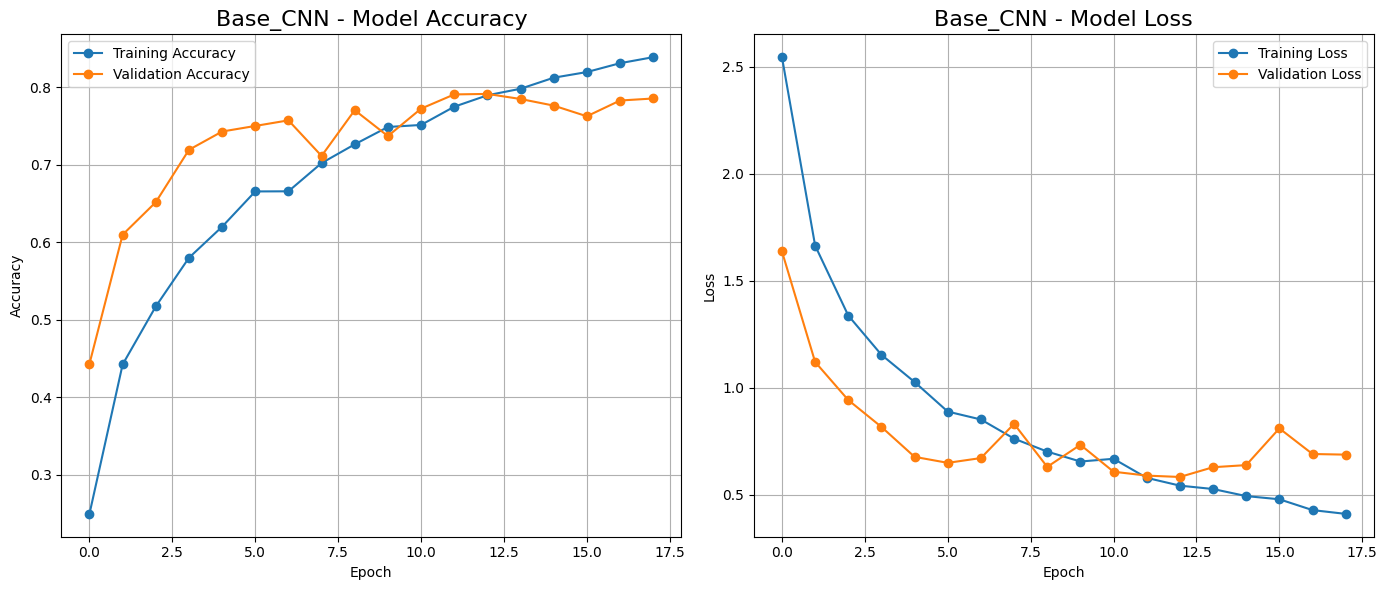


--- Full Evaluation for Base_CNN ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Classification Report for Base_CNN:
                                                 precision    recall  f1-score   support

                      AloeVera_Aloe_Anthracnose       0.27      0.17      0.21        41
                          AloeVera_Aloe_Healthy       0.38      0.48      0.42        44
                        AloeVera_Aloe_Leaf_Spot       0.30      0.16      0.21        45
                             AloeVera_Aloe_Rust       0.32      0.34      0.33        41
                          AloeVera_Aloe_Sunburn       0.34      0.52      0.41        44
Chrysanthemum_Chrysanthemum_Bacterial_Leaf_Spot       0.72      0.69      0.71        42
            Chrysanthemum_Chrysanthemum_Healthy       0.73      0.86      0.79        44
 Chrysanthemum_Chrysanthemum_Septoria_Leaf_Spot       0.97      0.86      0.92        44
                       Hibiscus_Hibiscus_Blight       0.93      0.89      0.91     

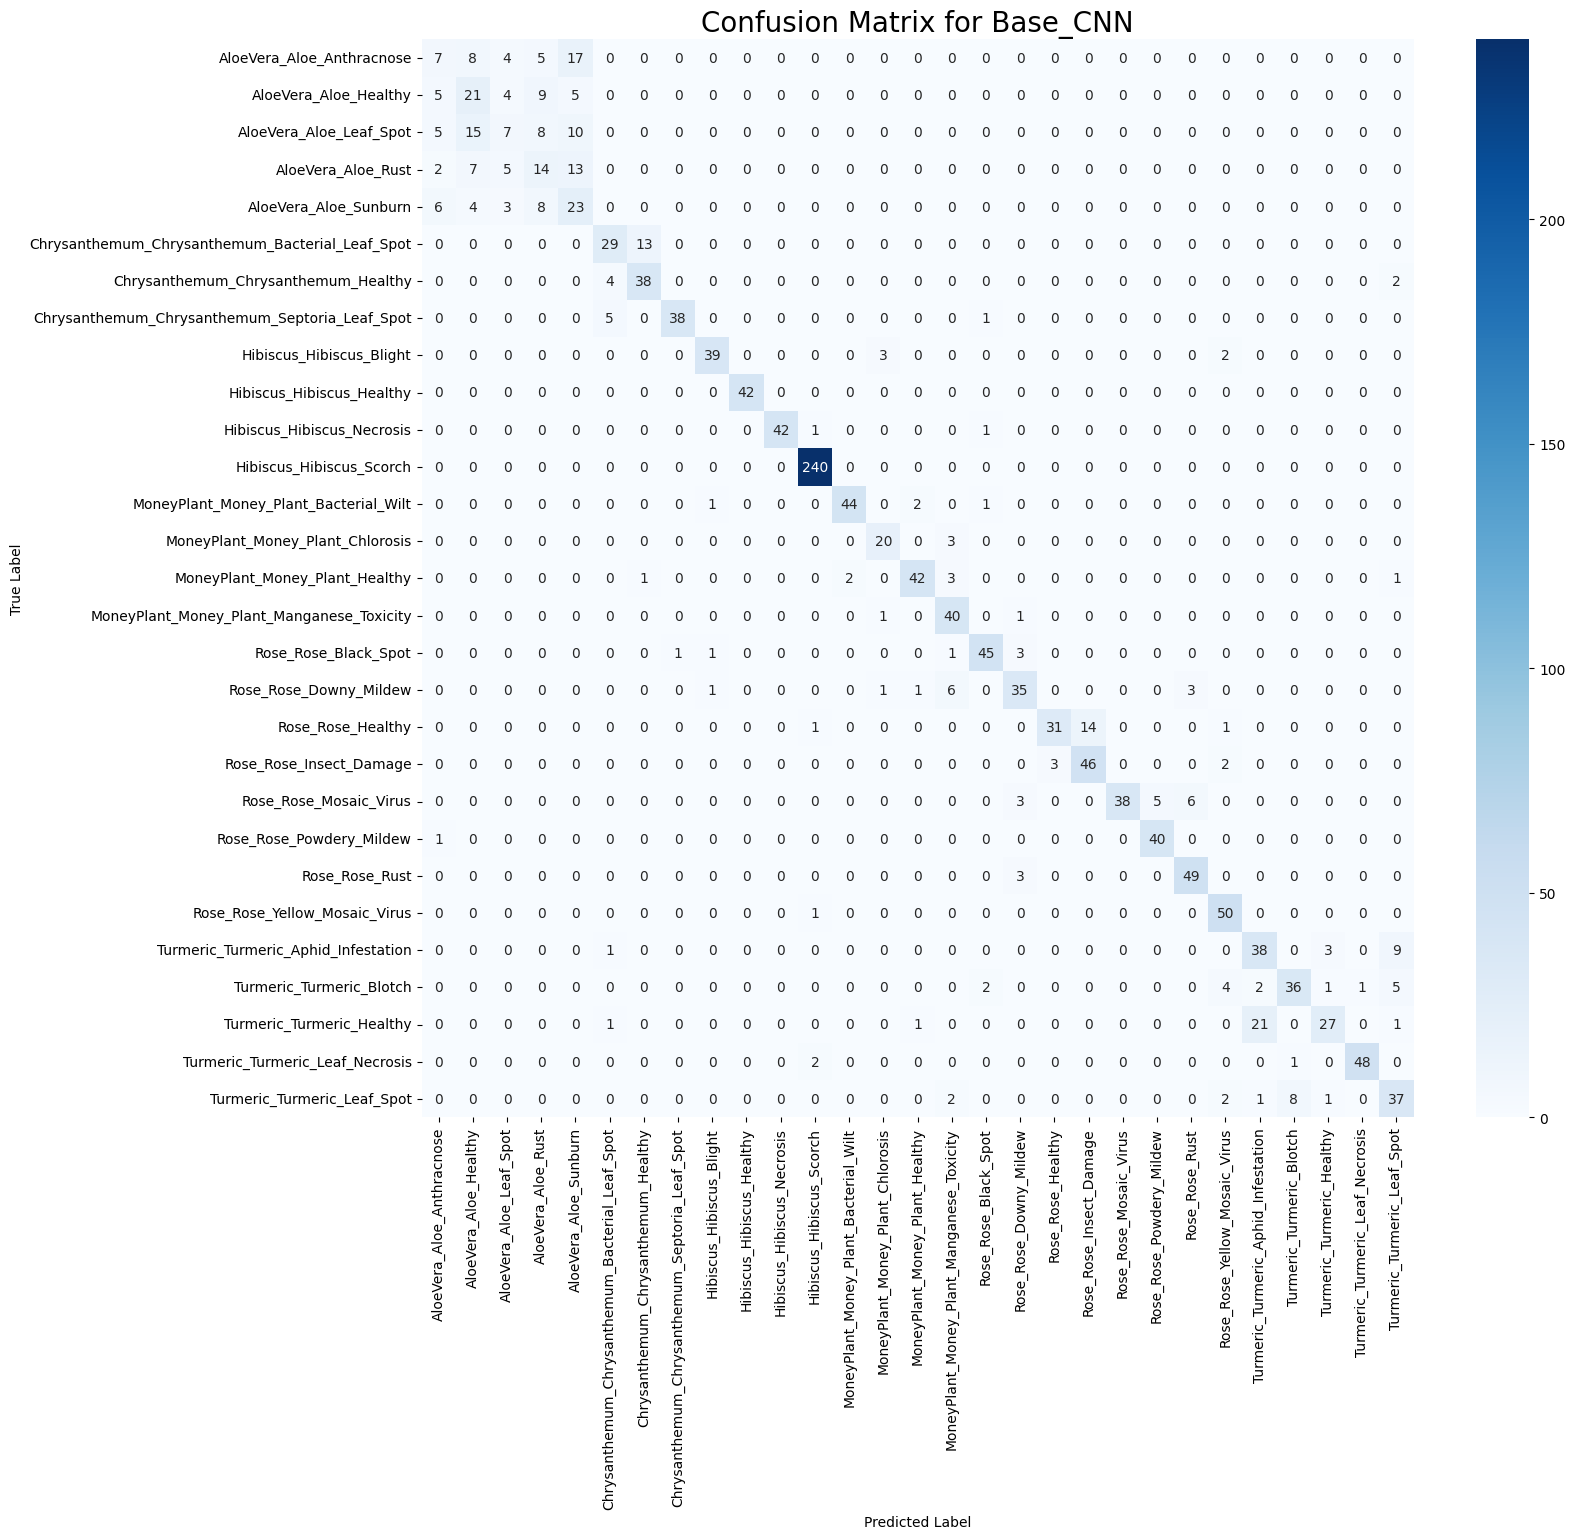

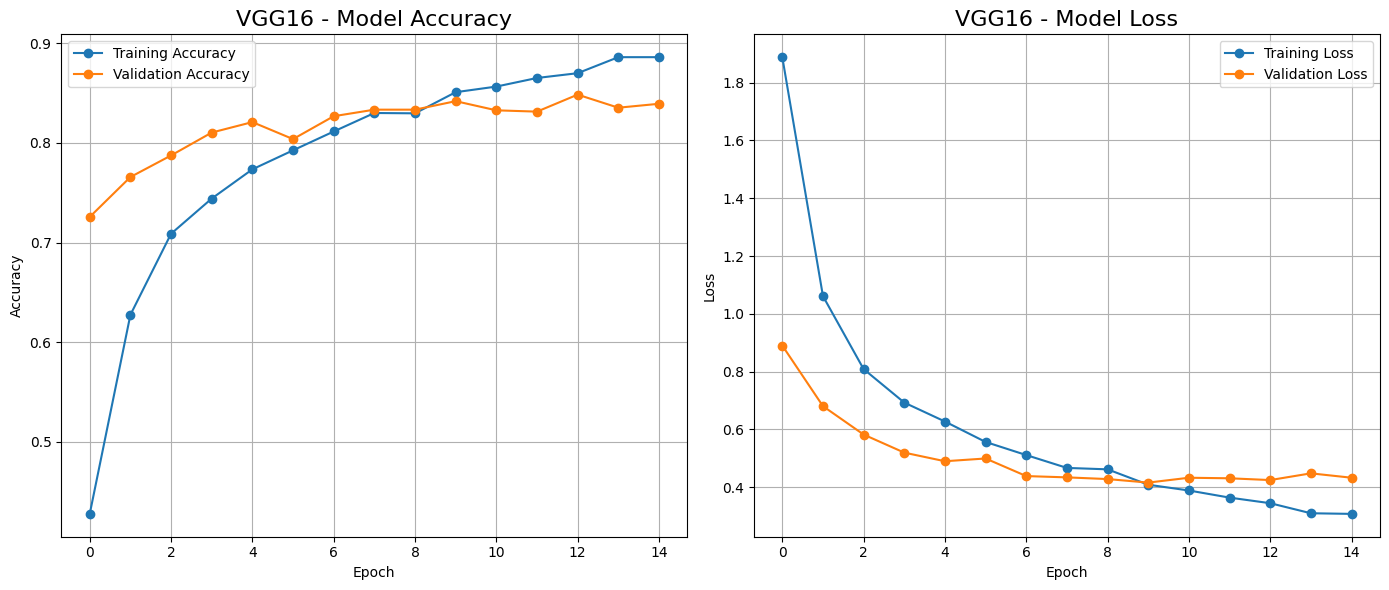


--- Full Evaluation for VGG16 ---


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step

Classification Report for VGG16:
                                                 precision    recall  f1-score   support

                      AloeVera_Aloe_Anthracnose       0.63      0.54      0.58        41
                          AloeVera_Aloe_Healthy       0.46      0.48      0.47        44
                        AloeVera_Aloe_Leaf_Spot       0.47      0.31      0.37        45
                             AloeVera_Aloe_Rust       0.41      0.68      0.51        41
                          AloeVera_Aloe_Sunburn       0.60      0.48      0.53        44
Chrysanthemum_Chrysanthemum_Bacterial_Leaf_Spot       0.96      0.57      0.72        42
            Chrysanthemum_Chrysanthemum_Healthy       0.72      0.95      0.82        44
 Chrysanthemum_Chrysanthemum_Septoria_Leaf_Spot       0.91      0.93      0.92        44
                       Hibiscus_Hibiscus_Blight       0.86      1.00      0.93        44
                      Hibiscus_Hibi

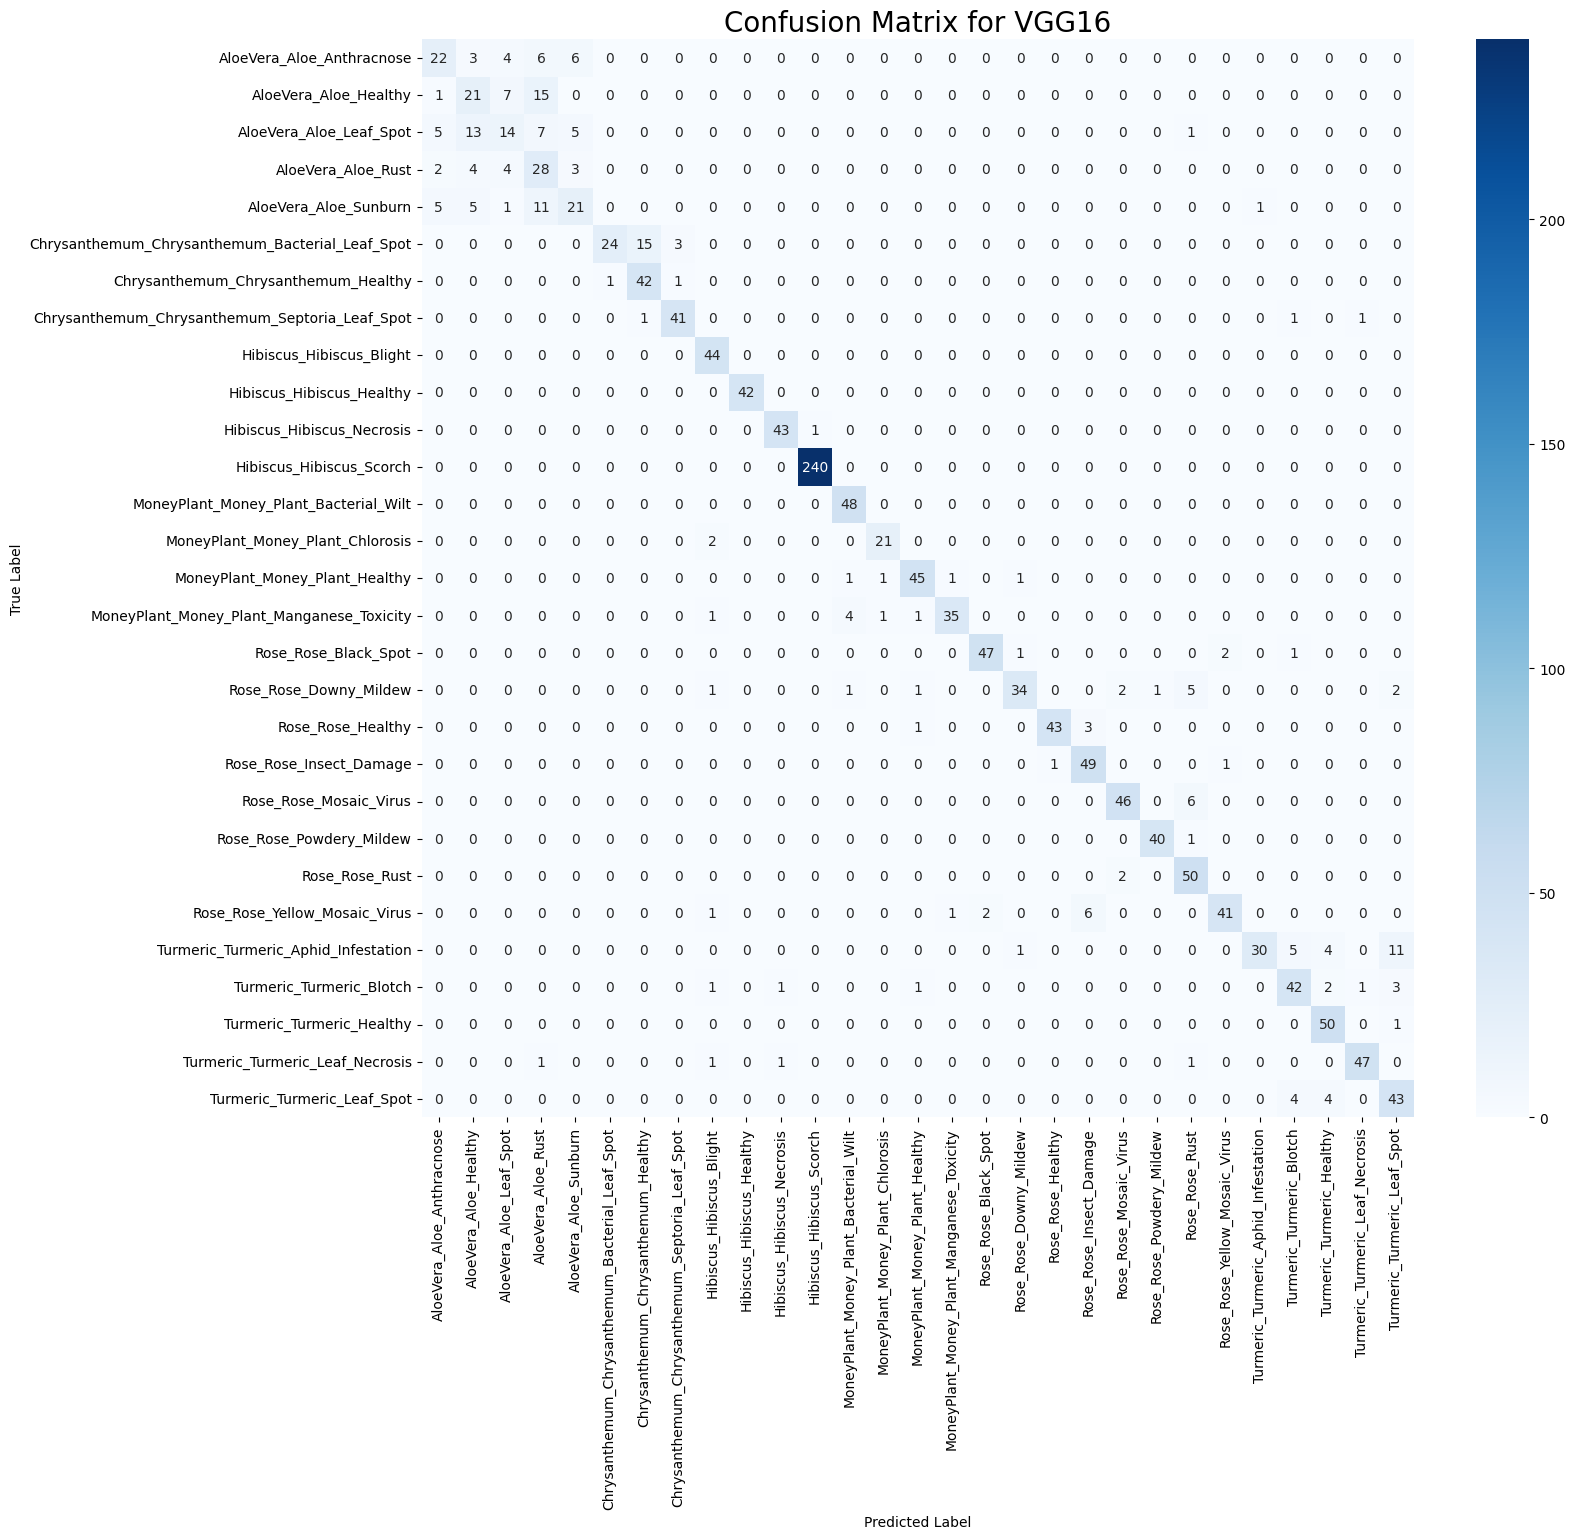

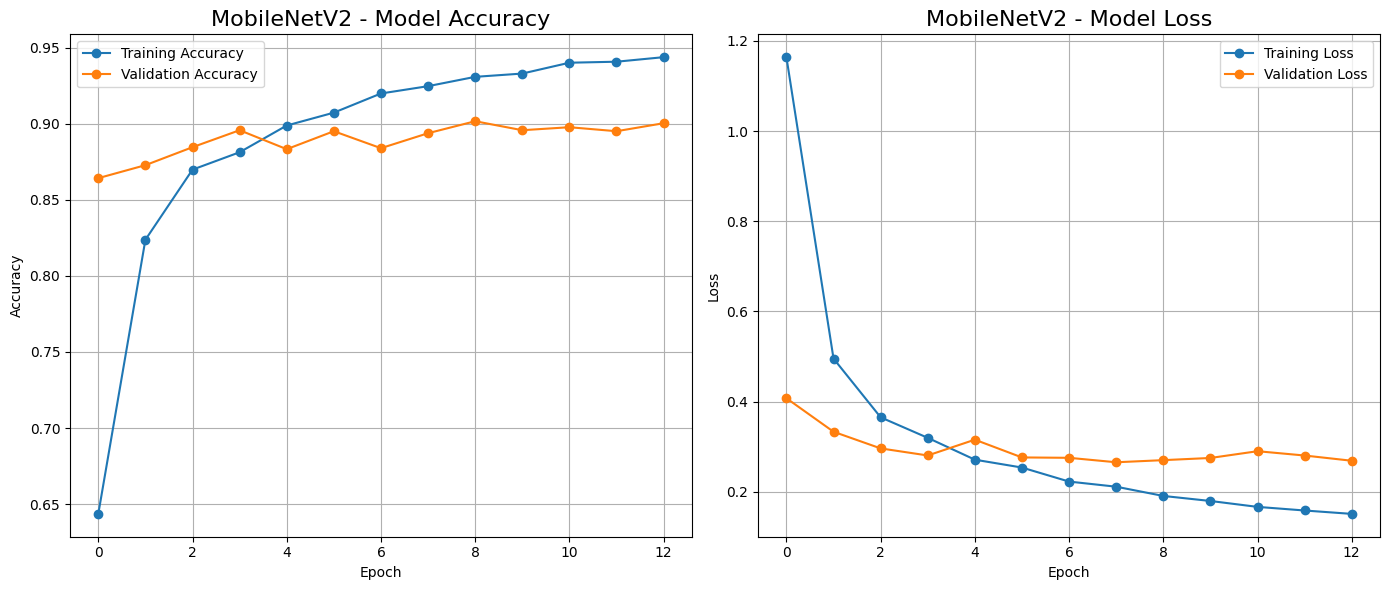


--- Full Evaluation for MobileNetV2 ---


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step

Classification Report for MobileNetV2:
                                                 precision    recall  f1-score   support

                      AloeVera_Aloe_Anthracnose       0.55      0.73      0.62        41
                          AloeVera_Aloe_Healthy       0.59      0.45      0.51        44
                        AloeVera_Aloe_Leaf_Spot       0.64      0.47      0.54        45
                             AloeVera_Aloe_Rust       0.44      0.56      0.49        41
                          AloeVera_Aloe_Sunburn       0.63      0.59      0.61        44
Chrysanthemum_Chrysanthemum_Bacterial_Leaf_Spot       0.90      0.90      0.90        42
            Chrysanthemum_Chrysanthemum_Healthy       0.91      0.95      0.93        44
 Chrysanthemum_Chrysanthemum_Septoria_Leaf_Spot       1.00      0.93      0.96        44
                       Hibiscus_Hibiscus_Blight       0.98      1.00      0.99        44
                      Hibis

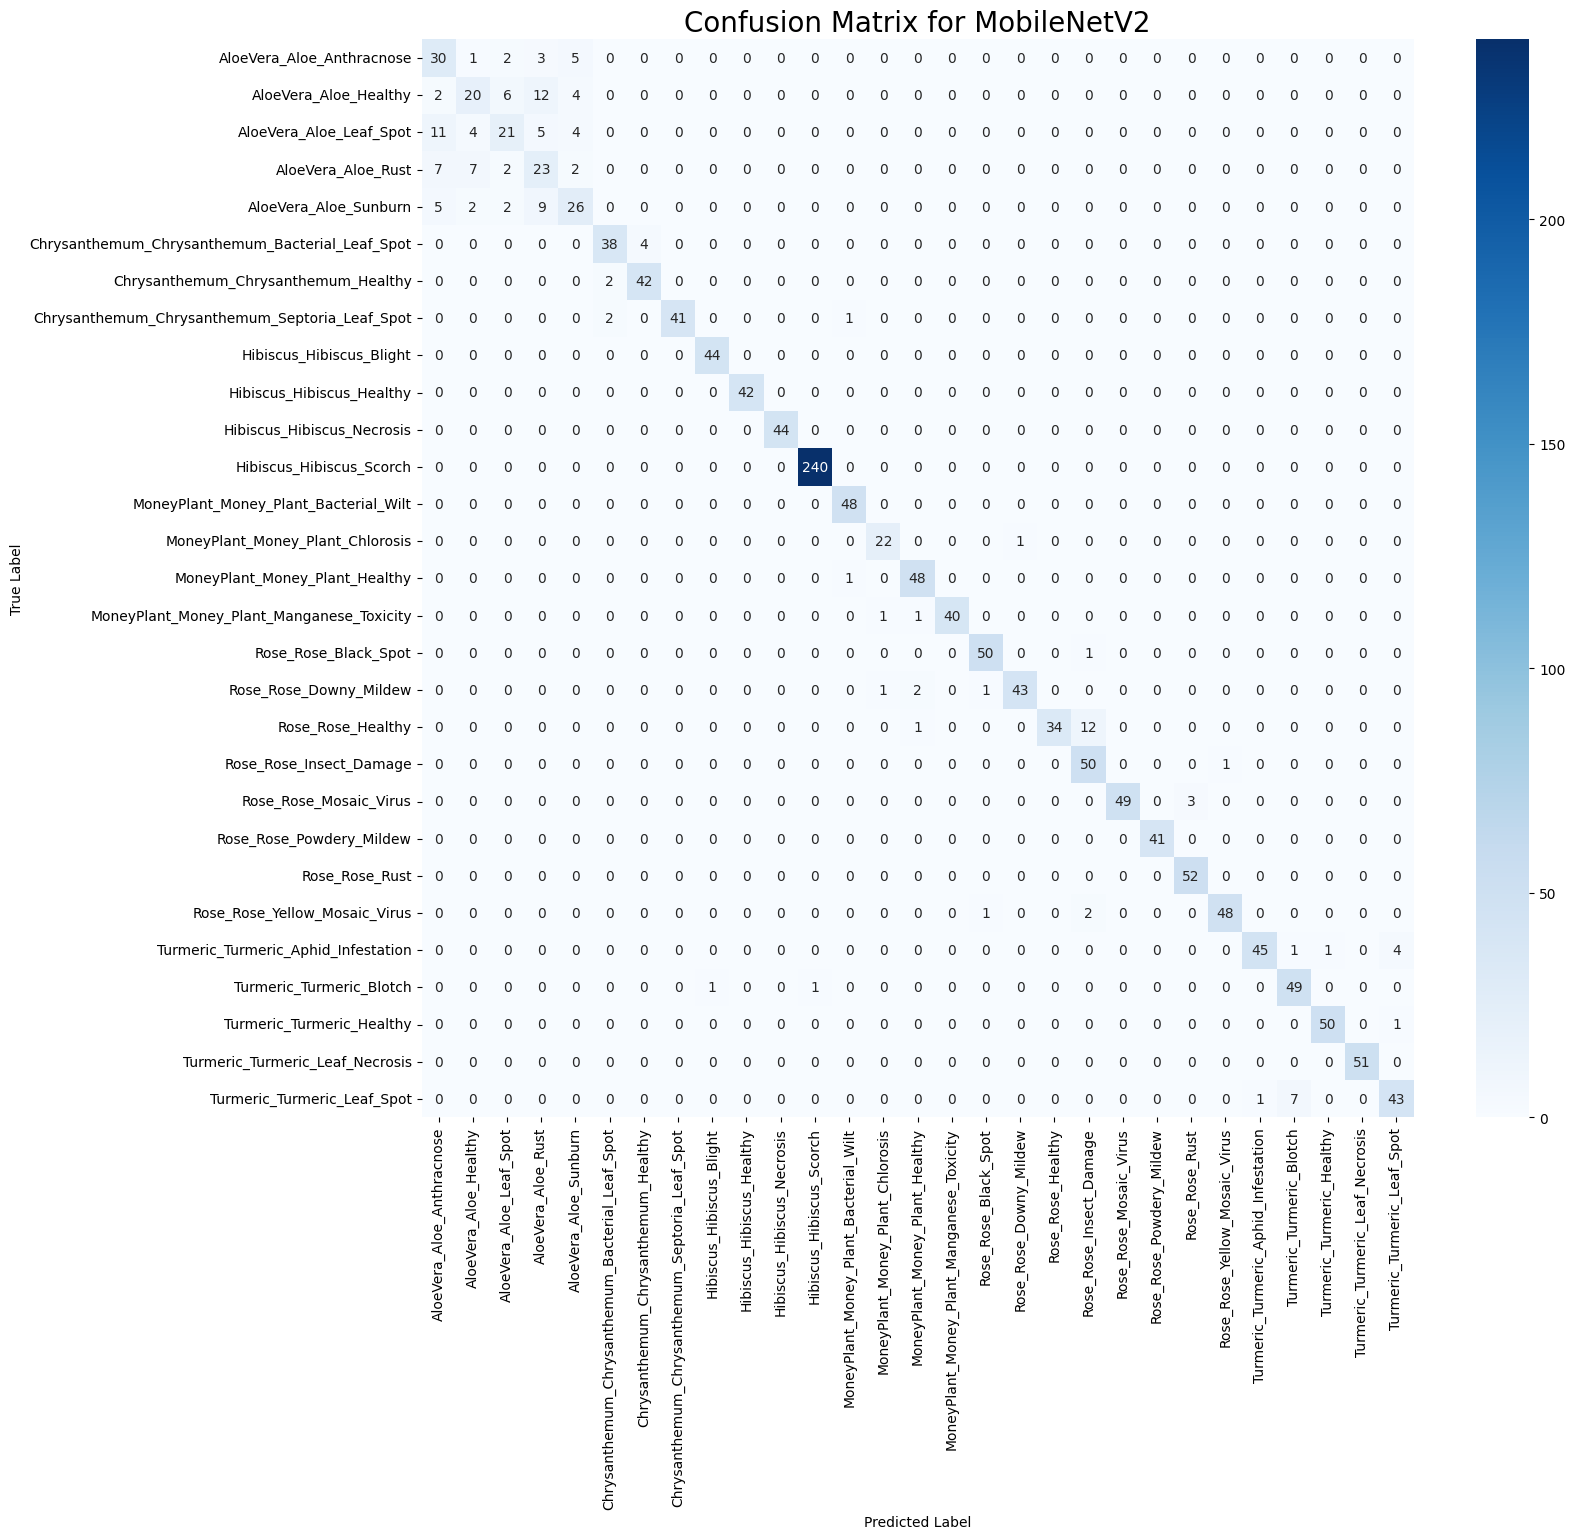


--- Loading Best Model for Final Pipeline: /content/drive/MyDrive/MobileNetV2.h5 ---


/tmp/ipython-input-2880826592.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(12, 10)); sns.barplot(x='Count', y='Class', data=class_counts_df, palette='viridis'); plt.title('Training Images Per Class'); plt.show()



CRITICAL ERROR: Could not load final pipeline components. [Errno 2] No such file or directory: '/content/drive/MyDrive/plant_knowledge_base.csv'
Please ensure your best model (.h5) and knowledge base (.csv) are in Google Drive.

--- [Final Report] System Demonstration ---

--- [Final Report] Ethical and Bias Analysis ---


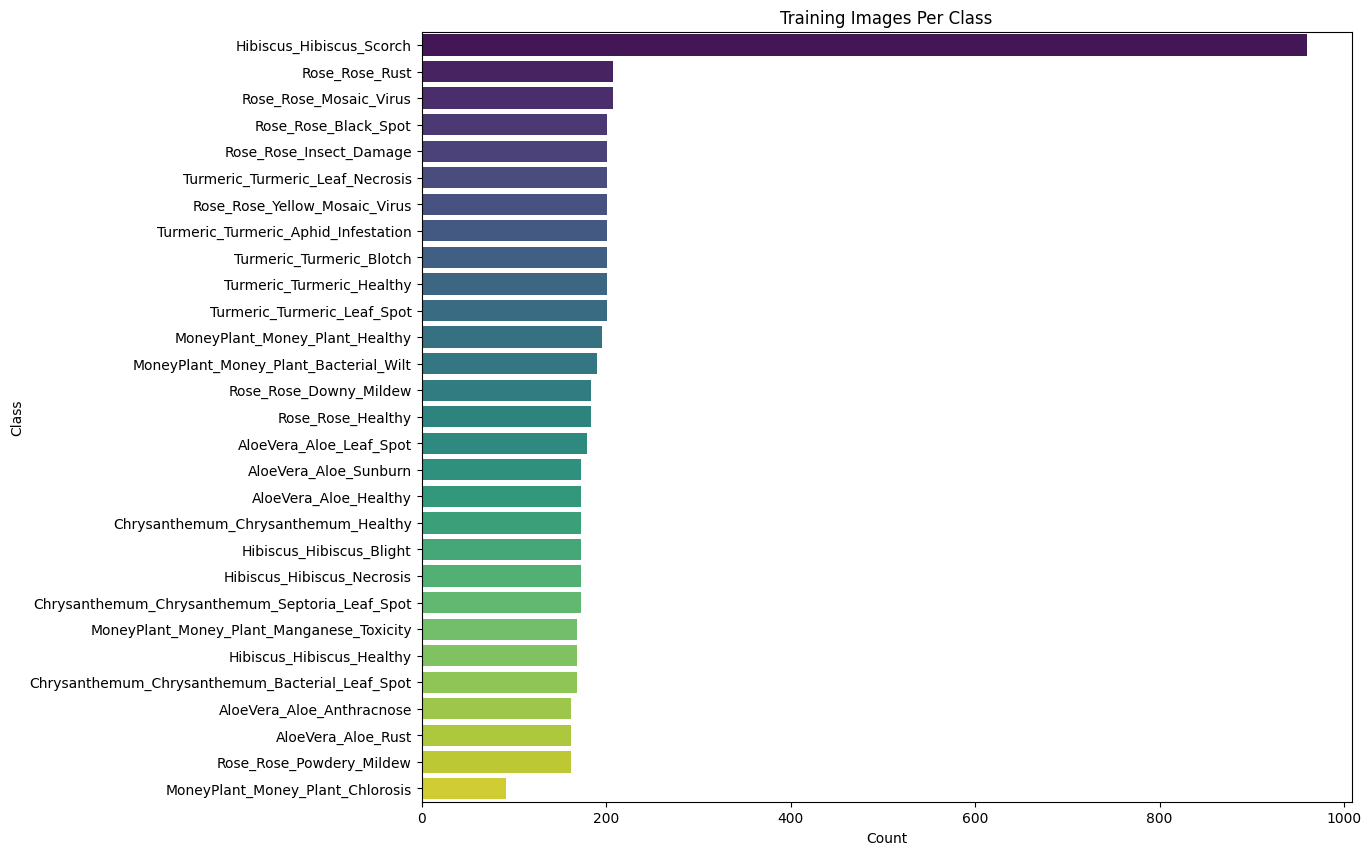


**Analysis for Report:**
Use this chart to discuss dataset imbalance. A significant difference between the most and least common classes can lead to model bias, affecting its reliability for rare diseases.

--- [Final Report] Model Comparison Summary Table ---

| Metric                  | Base CNN        | VGG16           | MobileNetV2         |
| :---------------------- | :-------------- | :-------------- | :------------------ |
| **Validation Accuracy** | **77.03%**      | **84.19%**      | **90.22%**          |
| **Precision (Macro Avg)** | *(Fill from report)* | *(Fill from report)* | *(Fill from report)*   |
| **Recall (Macro Avg)**    | *(Fill from report)* | *(Fill from report)* | *(Fill from report)*   |
| **Model Size (MB)**       | *(Check file size)* | *(Check file size)* | *(Check file size)* |



In [10]:
# =================================================================================
# BLOCK 3: FINAL EVALUATION, PIPELINE, AND REPORTING (PROGRESS REVIEW III)
# =================================================================================
# Run this block after all models have been trained (Block 2).

# --- 1. SETUP AND IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- 2. EVALUATION FUNCTIONS ---

# Task for Member 1: Plot Training History
def plot_history(model_name):
    """Loads and plots the training accuracy and loss curves for a model."""
    history_path = f'/content/drive/MyDrive/{model_name}_history.csv'
    if not os.path.exists(history_path):
        print(f"History file not found for {model_name}. Skipping plot.")
        return
    history_df = pd.read_csv(history_path)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'{model_name} - Model Accuracy', fontsize=16)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training Loss', marker='o')
    plt.plot(history_df['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'{model_name} - Model Loss', fontsize=16)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Task for Members 2 & 3: Generate Classification Reports & Confusion Matrices
def evaluate_model(model_name):
    """Loads a model and generates its classification report and confusion matrix."""
    model_path = f'/content/drive/MyDrive/{model_name}.h5'
    if not os.path.exists(model_path):
        print(f"Model file not found for {model_name}. Skipping evaluation.")
        return
    print(f"\n--- Full Evaluation for {model_name} ---")
    model = tf.keras.models.load_model(model_path)
    y_true_labels = np.concatenate([y for x, y in val_ds], axis=0)
    y_true_indices = np.argmax(y_true_labels, axis=1)
    predictions = model.predict(val_ds)
    y_pred_indices = np.argmax(predictions, axis=1)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true_indices, y_pred_indices, target_names=class_names))

    cm = confusion_matrix(y_true_indices, y_pred_indices)
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=20)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# --- 3. RUN MODEL EVALUATION ---
print("--- [Progress Review III] Generating Model Evaluations ---")
plot_history("Base_CNN")
evaluate_model('Base_CNN')
plot_history("VGG16")
evaluate_model('VGG16')
plot_history("MobileNetV2")
evaluate_model('MobileNetV2')

# --- 4. IMPLEMENT THE FINAL RECOMMENDATION PIPELINE ---

# Task for Member 4: Integrate the best model with the Knowledge Base
# Based on your training logs, MobileNetV2 is the best performer.
BEST_MODEL_PATH = '/content/drive/MyDrive/MobileNetV2.h5'
print(f"\n--- Loading Best Model for Final Pipeline: {BEST_MODEL_PATH} ---")

try:
    final_model = tf.keras.models.load_model(BEST_MODEL_PATH)
    knowledge_base_df = pd.read_csv('/content/drive/MyDrive/plant_knowledge_base.csv')
    print("Best model and knowledge base loaded successfully.")

    def predict_and_recommend(image_path):
        """
        Takes an image path, classifies it, and provides a full set of recommendations,
        including a remedy plan for diseases.
        """
        print(f"\n--- Running Prediction and Recommendation on: {image_path} ---")
        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(128, 128))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make prediction
        prediction = final_model.predict(img_array)
        class_index = np.argmax(prediction[0])
        class_name = class_names[class_index]
        confidence = 100 * np.max(prediction[0])

        # Display image and prediction
        plt.figure(figsize=(6,6))
        plt.imshow(img); plt.title(f"Prediction: {class_name} ({confidence:.2f}%)"); plt.axis('off'); plt.show()

        # Fetch and display recommendations
        recommendation = knowledge_base_df[knowledge_base_df['class_name'] == class_name]
        if recommendation.empty:
            print(f"Sorry, no information found in the Knowledge Base for '{class_name}'.")
            return

        rec_data = recommendation.to_dict('records')[0]
        is_diseased = 'Healthy' not in class_name
        remedy = rec_data.get('remedy_and_prevention')

        if is_diseased and pd.notna(remedy):
            print("\n--- 🩺 Recommended Action Plan ---")
            print(f"**Diagnosis:** The model detected signs of {class_name.replace('_', ' ')}.")
            print(f"**Remedy and Prevention Plan:**\n   {remedy}\n")
            print("-" * 30)

        print("\n--- General Plant Information ---")
        for key, value in rec_data.items():
            if key not in ['class_name', 'remedy_and_prevention'] and pd.notna(value):
                print(f"🌿 {key.replace('_', ' ').title()}:\n   {value}\n")

except FileNotFoundError as e:
    print(f"\nCRITICAL ERROR: Could not load final pipeline components. {e}")
    print("Please ensure your best model (.h5) and knowledge base (.csv) are in Google Drive.")

# --- 5. SYSTEM DEMONSTRATION FOR FINAL REPORT ---
# Action: Upload a healthy image and a diseased image to your Colab session.
# Then, uncomment the lines below and replace the filenames.
print("\n--- [Final Report] System Demonstration ---")
# predict_and_recommend('/content/your_healthy_plant_image.jpg')
# predict_and_recommend('/content/your_diseased_leaf_image.jpg')

# --- 6. ETHICAL AND BIAS ANALYSIS FOR FINAL REPORT ---
print("\n--- [Final Report] Ethical and Bias Analysis ---")
class_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in class_names}
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count']).sort_values('Count', ascending=False)
plt.figure(figsize=(12, 10)); sns.barplot(x='Count', y='Class', data=class_counts_df, palette='viridis'); plt.title('Training Images Per Class'); plt.show()
print("\n**Analysis for Report:**\nUse this chart to discuss dataset imbalance. A significant difference between the most and least common classes can lead to model bias, affecting its reliability for rare diseases.")

# --- 7. FINAL SUMMARY TABLE FOR REPORT ---
# Task for Member 5: Fill in the missing values in your report
print("\n--- [Final Report] Model Comparison Summary Table ---")
# Use the Classification Reports and training logs to fill this out.
# Check the .h5 file sizes in your Google Drive.
print("""
| Metric                  | Base CNN        | VGG16           | MobileNetV2         |
| :---------------------- | :-------------- | :-------------- | :------------------ |
| **Validation Accuracy** | **77.03%**      | **84.19%**      | **90.22%**          |
| **Precision (Macro Avg)** | *(Fill from report)* | *(Fill from report)* | *(Fill from report)*   |
| **Recall (Macro Avg)**    | *(Fill from report)* | *(Fill from report)* | *(Fill from report)*   |
| **Model Size (MB)**       | *(Check file size)* | *(Check file size)* | *(Check file size)* |
""")